<a href="https://colab.research.google.com/github/00150/AI_07_JYP_Project_section_02/blob/main/Classification_Used_car_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필요한 라이브러리를 설치합니다.
!pip3 install pdpbox
!pip3 install xgboost==1.7.2
!pip3 install eli5
!pip install category_encoders
!pip3 install imbalanced-learn # undersampling + oversampling을 진행할 라이브러리 입니다.
!pip install scikit-learn==1.0 -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0
    Uninstalling scikit-learn-1.0:
      Successfully uninstalled scikit-learn-1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.7 MB)
  Attempting uninstall: scikit-learn


In [2]:
# 모델링을 진행할 데이터를 가져옵니다.
# 필요한 라이브러 및 패키지는 그때 그때 가져오도록 합니다.
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/00150/AI_07_JYP_Project_section_02/main/audi_eda').drop('Unnamed: 0', axis = 1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9345 entries, 0 to 9344
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          9345 non-null   object 
 1   year           9345 non-null   int64  
 2   price          9345 non-null   int64  
 3   transmission   9345 non-null   object 
 4   mileage        9345 non-null   int64  
 5   fuelType       9345 non-null   object 
 6   tax            9345 non-null   int64  
 7   mpg            9345 non-null   float64
 8   engineSize     9345 non-null   float64
 9   size_and_type  9345 non-null   object 
 10  size           9345 non-null   object 
 11  type           9344 non-null   object 
 12  used_year      9345 non-null   int64  
 13  ampy           9345 non-null   float64
 14  km/l           9345 non-null   float64
dtypes: float64(4), int64(5), object(6)
memory usage: 1.1+ MB


앞서 EDA & Visualization 을 진행한 데이터에는 다음과 같은 컬럼이 존재합니다.

* 각각의 컬럼은 다음과 같습니다. 
  - model : 자동차의 모델명 
  - year : 연식 
  - price : 가격 
  - transmission : 변속기
  - mileage : 자동차 주행거리
  - fuelType : 자동차 연료의 유형
  - tax : 세금(자동차)
  - mpg(Miles per Gallon) : 자동차 연비(Fuel efficiency)
  - engineSize :엔진 크기
  - size_and_type :차량의 사이즈 및 타입
  - size : 차량의 사이즈
  - type : 차량의 유형
  - used_year : 차를 사용한 연도
  - ampy : 연간 평균 주행거리.
  - km/l : 자동차 연비(한국식 표현)

In [4]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,size_and_type,size,type,used_year,ampy,km/l
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,small_hatchback,small,hatchback,6,2622.5,23.8
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,subfull_sedan,subfull,sedan,7,5171.9,27.6
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,small_hatchback,small,hatchback,7,4278.0,23.8
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,mid_sedan,mid,sedan,6,4325.3,28.9
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,submid_hatchback,submid,hatchback,4,499.5,21.3


In [5]:
df.nunique()

model              25
year                7
price            2864
transmission        3
mileage          6727
fuelType            3
tax                27
mpg                84
engineSize         15
size_and_type      15
size                6
type                6
used_year           7
ampy             6872
km/l               83
dtype: int64

#1. Feature Engineering
> 기존 데이터에서 추가로 이용할 수 있는 부분이 있다면 새로운 피처를 생성합니다.

 -  Good preference badge 추가하기. <br>
 차량을 사용한 이력이 3~5년사이, 주행거리가 30000이하, 자동차 연비(기준:km/l)가 21 이상이라면 뱃지를 달아줍니다.

 - 차량 모델에 상관없이 상태가 좋은 중고차를 구매하려고 하는 사람들이 분명 존재합니다. <br/>
   이들에게 추천해줄 수 있도록 분류하는 모델을 생성하고자 합니다.



In [6]:
# np.select() method를 이용합니다.
import numpy as np
conditionlist = [(df['used_year'] <=5) & (df['mileage'] <=30000) & (df['km/l'] >=21)]
select_data = ['good']

df['good_badge']  = np.select(conditionlist, select_data, default = 'Not Specified')

Not Specified    0.880257
good             0.119743
Name: good_badge, dtype: float64


Not Specified    8226
good             1119
Name: good_badge, dtype: int64


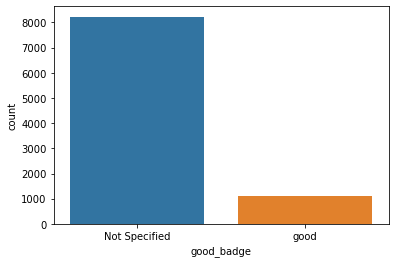

In [7]:
# 타겟 비율 확인
print(df['good_badge'].value_counts(normalize=True))
print('\n')
print(df['good_badge'].value_counts())

# 시각화 - 필요한 라이브러리 가져오기.
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x = df['good_badge'])

현재 타겟은 **불균형한 데이터 값**을 보여주고 있습니다.
* 모델 생성시 이 부분에 유의하여 모델을 생성하도록 합니다.

---

#2.  Model : `DecisionTree`

#### 2-1. Baseline 생성.
>기준모델로 최다 비율 클래스를 사용할 경우 정확도는 다음과 같습니다.

In [8]:
# 타겟값을 mapping 하도록 합니다.
# Not Specified = 0, good = 1
y_train = df['good_badge'].replace(['Not Specified', 'good'], [0,1])

# 기준 모델 생성 - 필요한 라이브러리 가져오기.
from sklearn.metrics import accuracy_score

major = y_train.mode()[0]


# 최다빈도 값 : 0이 담긴 리스트를 생성합니다. 
major = y_train.mode()[0]
y_pred = [major] * len(y_train)

# 기준모델의 정확도는 다음과 같습니다.
print(f'baseline accuracy:{accuracy_score(y_train, y_pred)}')

baseline accuracy:0.8802568218298555


####2-2. `ML : DecisionTreeClassifier` 생성.

In [9]:
# 데이터 분할.
from sklearn.model_selection import train_test_split

# 타겟 데이터를 같은 비율로 분할합니다.
train, val = train_test_split(df,
                                  train_size = 0.75,
                                  stratify = df['good_badge'],random_state = 42)


# target & feature 지정.
target = 'good_badge'
features = df.columns.drop(['size_and_type','mpg',target])

# train
y_train = train[target]
X_train = train[features]

# val
y_val = val[target]
X_val = val[features]

# shap
print( X_train.shape, X_val.shape,'\n'*2)
print(y_train.value_counts(normalize=True),'\n'*2, y_val.value_counts(normalize=True),'\n'*2)

(7008, 13) (2337, 13) 


Not Specified    0.88028
good             0.11972
Name: good_badge, dtype: float64 

 Not Specified    0.880188
good             0.119812
Name: good_badge, dtype: float64 




In [10]:
X_train.columns, X_val.columns

(Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
        'engineSize', 'size', 'type', 'used_year', 'ampy', 'km/l'],
       dtype='object'),
 Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
        'engineSize', 'size', 'type', 'used_year', 'ampy', 'km/l'],
       dtype='object'))

In [11]:

# 데이터 인코딩 및 파이프라인 생성 : 필요한 라이브러리 가져오기.
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth = 5, random_state=42))

print(pipe)

#eval_set
pipe.fit(X_train, 
          y_train)

print('검증 정확도:', pipe.score(X_val,y_val))

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])
검증 정확도: 1.0


**검증 정확도가 1이 나왔습니다😥**
>모델을 시각화하여 과적합을 일으키는 컬럼을 확인합니다.

*`column: 'km/l'`을 지운 후 다시 한 번 살펴봅니다. 

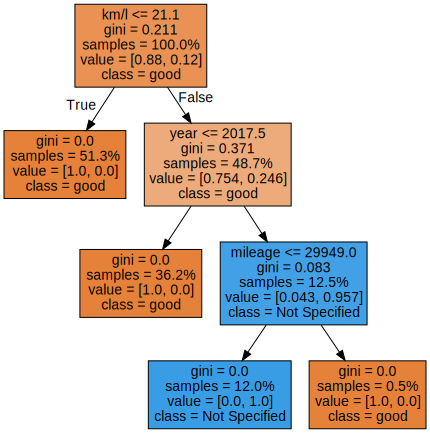

In [12]:
import graphviz
from sklearn.tree import export_graphviz

# 파이프라인에서 xgbclassifier에 접근.
tree = pipe.named_steps['decisiontreeclassifier']


dot_data = export_graphviz(
    tree,
    feature_names= X_train.columns,
    class_names = y_train.unique().astype(str),
    filled = True,
    proportion = True,
)

graphviz.Source(dot_data)

In [13]:
# 'km/l 제거'
features = df.columns.drop(['size_and_type','mpg','km/l',target])

# train
X_train = train[features]
y_train = train[target]

# val
X_val = val[features]
y_val = val[target]

# 새로운 파이프라인 생성.
pipe = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth = 5,
                           random_state = 42))


# fit
pipe.fit(X_train, y_train)
print(f'검증 정확도:{pipe.score(X_val, y_val)}')

검증 정확도:0.9490800171159607


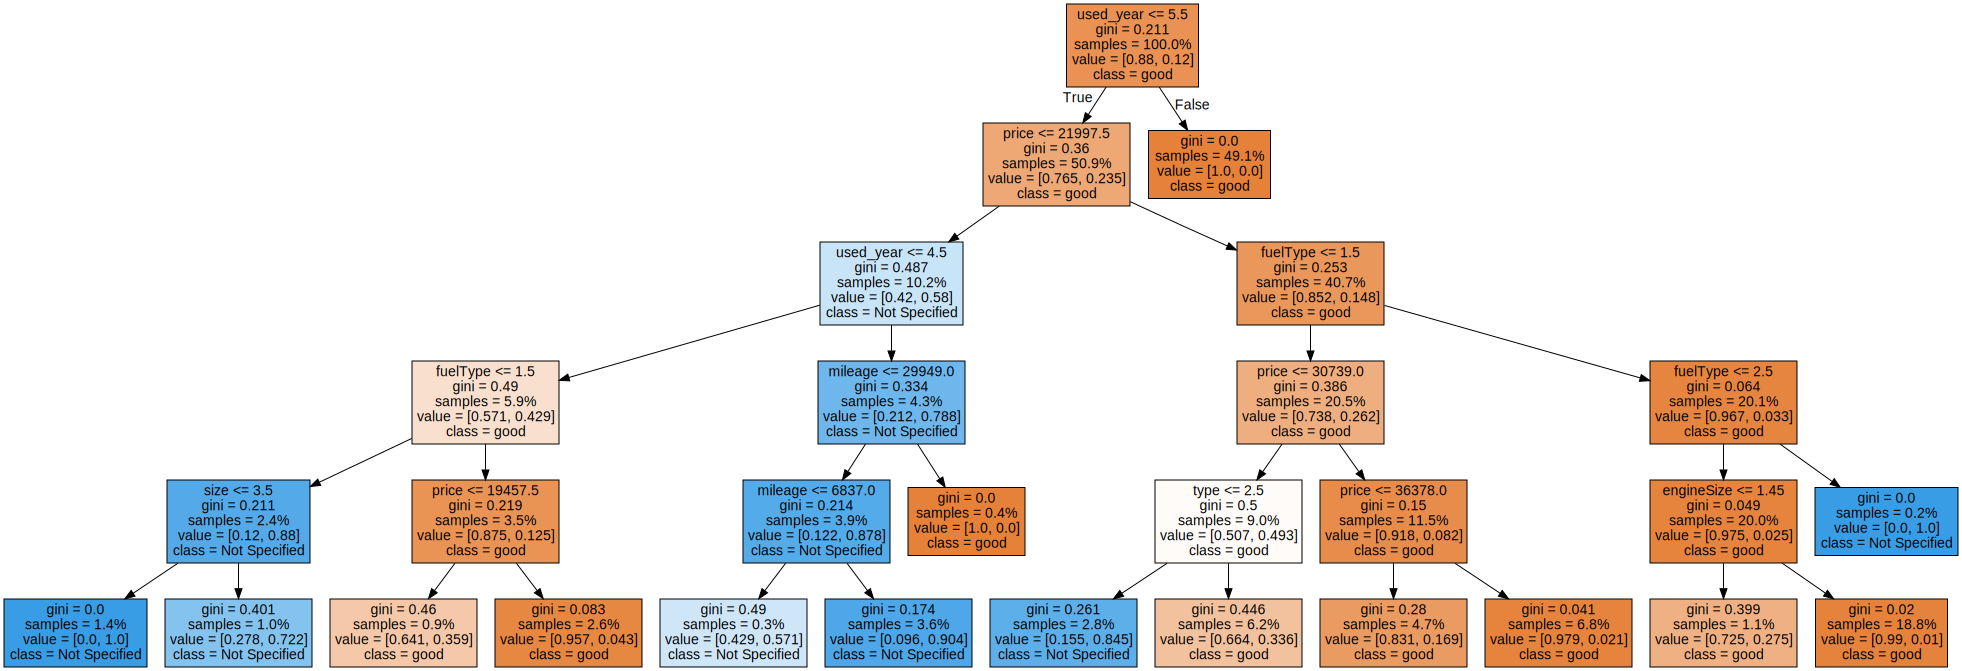

In [14]:
# 트리를 다시 한 번 시각화하여 봅시다.
tree = pipe.named_steps['decisiontreeclassifier']


dot_data = export_graphviz(
    tree,
    feature_names= X_train.columns,
    class_names = y_train.unique().astype(str),
    filled = True,
    proportion = True,
)

graphviz.Source(dot_data)

#### 2-3. Feature Importances : Mean decrease impurity
> 모델 학습 이후의 특성 중요도 값을 살펴보도록 합니다.

* 특성 중요도의 수치값을 확인합니다.


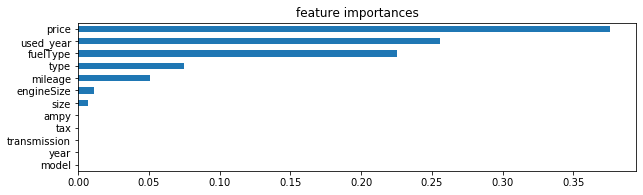

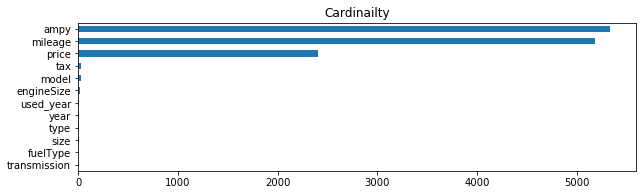

In [15]:
# 특성 중요도  그래프 생성 : subplots 2행 1열 그래프 생성.
# 필요한 라이브러리 가져오기.
from matplotlib.gridspec import GridSpec

# 1-1. 파이프라인의 랜덤포레스트 접근
rf = pipe.named_steps['decisiontreeclassifier']

# 1-2. 중요도 : 분류 데이터의 경우, 'rf.feature_importances_'로 접근합니다.
importances = pd.Series(rf.feature_importances_, X_train.columns).sort_values(ascending = False)

# 1-3. 데이터프레임 변환
import_df = pd.DataFrame(importances, columns = ['importances'])
import_df
                          
# 1-4. 피처 중요도 및 카디널리티 시각화 진행
plt.figure(figsize = (10,6))
ax_1 = plt.subplot(2,1,1)
graph1 = importances.sort_values().plot.barh()
ax_1.set_title('feature importances')
plt.show()

# 1-5. 그래프 지정: 카디널리티
plt.figure(figsize = (10,6))
ax_2 = plt.subplot(2,1,2)
X_train.nunique().sort_values().plot.barh()
ax_2.set_title('Cardinailty')
plt.show()

**Feature Importance의 주의할 점 : High Cardinality**
* MDI 기반 Feature Importance는  High Cardinality 특성에 높은 값을 부여하는 문제가 존재한다.
  * 매 노드 분할 시, Cardinality가 높은 특성이 분할 기준 특성이 될 확률이 높기 때문입니다.
  * 다행스럽게도 높은 카디널리티 값을 갖는 ampy가 높은 중요도를 가지고 있지는 않습니다.

####2-4. Evaluation Mertircs : `DecisionTreeClassifier ` 
> 타겟 클래스 비용이 70% 이상 차이난다면 정확도만 사용하여 판단할 수 없습니다. (정확하지 않기 때문)

* 정밀도, 재현율, Roc-AUC등을 같이 사용하여 확인하여 봅시다.

**Confusion Matrix를 생성합니다.**

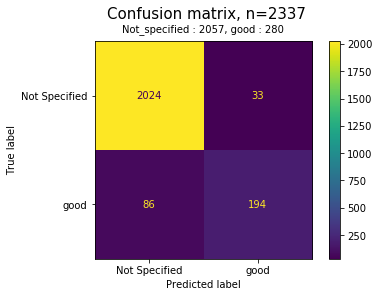

In [16]:
# 필요한 라이브러리를 가져옵니다.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 예측값 생성.
y_pred = pipe.predict(X_val)

# confusionmatrix 생성.
cm = confusion_matrix(y_val,
                      y_pred,
                      labels = pipe.named_steps['decisiontreeclassifier'].classes_)

# display
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = pipe.named_steps['decisiontreeclassifier'].classes_)

disp.plot()
plt.suptitle(f'Confusion matrix, n={len(y_val)}', fontsize = 15,y=1)
plt.title(f'Not_specified : {y_val.value_counts()[0]}, good : {y_val.value_counts()[1]}', fontsize =10, pad = 10)
plt.show()

**classification_report 또한 살펴봅니다**

In [17]:
# classification_report 생성.
from sklearn.metrics import classification_report
y_pred = pipe.predict(X_val)
print(classification_report(y_val,y_pred))

               precision    recall  f1-score   support

Not Specified       0.96      0.98      0.97      2057
         good       0.85      0.69      0.77       280

     accuracy                           0.95      2337
    macro avg       0.91      0.84      0.87      2337
 weighted avg       0.95      0.95      0.95      2337



**ROC-AUC 커브를 시각화 및 Score 확인.**

In [18]:
# 필요한 라이브러리 가져오기.
from sklearn.metrics import roc_curve, roc_auc_score

# 점수 및 시각화에 대한 함수 생성 : get_roc_score
def get_roc_auc(model, X_val_encoded, y_val):
  
  # 우리가 생성한 모델이 XGBClassifier 이라면...
  if isinstance(model, XGBClassifier):
    y_pred_proba = model.predict_proba(
        X_val_encoded, 
        iteration_range = (0, model.best_iteration))[:,1]
  
  # 다른 모델을 생성했다면...
  else :
    y_pred_proba = model.predict_proba(X_val_encoded)[:,1]
  

  # try ~ except 생성.
  try :
    print(f'ROC-AUC: {roc_auc_score(y_val,y_pred_proba)} \n')

    # ROC-AUC : baseline 생성
    baseline_fpr, baseline_tpr, _ = roc_curve(y_val, [0]*len(y_val))

    # ROC-AUC : modelline 생성(baseline과 비교할 모델 값.)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

    # fpr, tpr, threshold를 살펴볼 수 있는 df 생성.
    tmp = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})

    # plot : baseline 생성.
    plt.plot(baseline_fpr, baseline_tpr, linestyle = '--', color = 'green', label='Baseline')
  
  except ValueError as ve :
    y_val_replaced = y_val.replace(('Not Specified', 'good'),(0,1))
    print('ValiueError 로 인하여 타겟값 맵핑을 완료하였습니다.\n Not Specified = 0, good = 1 \n') 
    print(f'ROC-AUC값을 다시 한 번 출력합니다 : {roc_auc_score(y_val,y_pred_proba)} \n')
    
    # ROC-AUC : baseline 생성
    baseline_fpr, baseline_tpr, _ = roc_curve(y_val_replaced, [0]*len(y_val))

    # ROC-AUC : modelline 생성(baseline과 비교할 모델 값.)
    fpr, tpr, thresholds = roc_curve(y_val_replaced, y_pred_proba)

    # fpr, tpr, threshold를 살펴볼 수 있는 df 생성.
    tmp = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})

    # plot : baseline 생성.
    plt.plot(baseline_fpr, baseline_tpr, linestyle = '--', color = 'green', label='Baseline')

  # plot :modelline
  plt.plot(fpr, tpr, color = 'blue', label = 'Model') 
  plt.scatter(fpr, tpr, color = 'red')
  plt.legend()
  plt.title('Roc Curve')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.show()
  return tmp

In [19]:
pipe.named_steps['decisiontreeclassifier'].classes_

array(['Not Specified', 'good'], dtype=object)

ROC-AUC: 0.96832158483228 

ValiueError 로 인하여 타겟값 맵핑을 완료하였습니다.
 Not Specified = 0, good = 1 

ROC-AUC값을 다시 한 번 출력합니다 : 0.96832158483228 



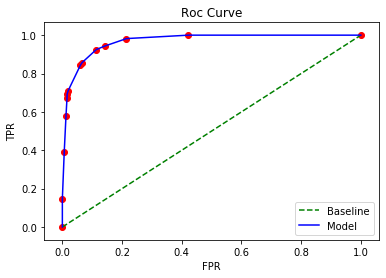

,fpr,tpr,thresholds
0,0.000000,0.000000,2.000000
1,0.000000,0.146429,1.000000
2,0.006320,0.392857,0.904000
3,0.012154,0.578571,0.845361
4,0.015557,0.671429,0.722222
5,0.016043,0.692857,0.571429
6,0.019446,0.710714,0.359375
7,0.060282,0.842857,0.335632
8,0.066116,0.857143,0.275000
9,0.113758,0.925000,0.168675


In [20]:
%matplotlib inline
get_roc_auc(pipe, X_val, y_val)

####2-5. DATA INSIGHT : `DecisionTreeClassifier`
* 타겟값이 불균형한 지표를 보여줬으나, 정확도는 매우 높은 값을 자랑하였습니다.
* classification report를 사용한 결과 최다빈도의 타겟 값은 잘 맞추지만, 적은 빈도 값의 재현율은 다소 낮았습니다.(70% 미만 확률) <br/>
* Roc - Curve가 직선과 비슷하게 나왔다면 분류가 잘 안된 것을 의미합니다.(회귀의 R2_score 처럼 나온 것이다.)<br/>

**주의❗)타겟 불균형이 존재할 때에는 AUC가 실제 성능에 비해 높게 계산됩니다.**<br/>

---



#3. Model : `XGBoost (불균형 vs 불균형 제거)`
> 데이터를 살펴봤을 때, 현재 타겟값이 불균형 클래스임을 알고 있습니다. 

* 불균형한 타겟 비율을 맞춰주기 위한 기법을 이용하도록 합니다.
* `xgboost` 라이브러리의 `scale_pos_weight` 파라미터로 가중치를 조정합니다.

❗불균형 타겟을 해소하지 않은 모델 및 해소한 모델의 값을 비교해보도록 합니다.

#### 3-1. 불균형 데이터를 기반으로한 `XGBClassifier`

In [21]:
# 인코딩을 진행할 인스턴스 객체를 생성합니다. : OrdinalEncoder
enc = OrdinalEncoder()

#--- applied data set(train, val)
X_train_encoded = enc.fit_transform(X_train)
X_val_encoded = enc.transform(X_val)

# 타겟 값을 맵핑합니다. 'good' = 1, // 'Not Specified' = 0
y_train_encoded = y_train.replace(['good', 'Not Specified'],[1,0])
y_val_encoded = y_val.replace(['good', 'Not Specified'],[1,0])

# created model
model = XGBClassifier(
    n_estimators =987654321,
    max_depth = 5,
    objective = 'binary:logistic',
    eval_metric = 'auc',
    learning_rate = 0.1,
    early_stopping_rounds = 50,
    n_jobs = -1,
    random_state = 42
)

# eval_set 생성 (early_stopping_round)
watchlist = [(X_train_encoded, y_train_encoded), (X_val_encoded, y_val_encoded)]


model.fit(X_train_encoded, 
          y_train_encoded,
          eval_set = watchlist)

[0]	validation_0-auc:0.97202	validation_1-auc:0.96842
[1]	validation_0-auc:0.97698	validation_1-auc:0.97479
[2]	validation_0-auc:0.97796	validation_1-auc:0.97495
[3]	validation_0-auc:0.98201	validation_1-auc:0.97985
[4]	validation_0-auc:0.98179	validation_1-auc:0.97940
[5]	validation_0-auc:0.98333	validation_1-auc:0.98132
[6]	validation_0-auc:0.98317	validation_1-auc:0.98157
[7]	validation_0-auc:0.98408	validation_1-auc:0.98219
[8]	validation_0-auc:0.98441	validation_1-auc:0.98239
[9]	validation_0-auc:0.98564	validation_1-auc:0.98380
[10]	validation_0-auc:0.98544	validation_1-auc:0.98323
[11]	validation_0-auc:0.98651	validation_1-auc:0.98481
[12]	validation_0-auc:0.98665	validation_1-auc:0.98499
[13]	validation_0-auc:0.98682	validation_1-auc:0.98506
[14]	validation_0-auc:0.98688	validation_1-auc:0.98517
[15]	validation_0-auc:0.98706	validation_1-auc:0.98534
[16]	validation_0-auc:0.98751	validation_1-auc:0.98600
[17]	validation_0-auc:0.98750	validation_1-auc:0.98608
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=987654321, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

분류 모델의 검증 정확도를 확인하여 봅시다.

In [22]:
# 필요한 라이브러리 가져오기.
from sklearn.metrics import roc_auc_score

def score(model):
  if isinstance(model, XGBClassifier):
    # 모델의 best_iteration 값은 다음과 같습니다.
    print(f'model의 best_iteration: {model.best_iteration}\n')

    # 모델의 정확도는 다음과 같습니다.
    print(f'검증데이터를 통한 모델의 정확도 : {model.score(X_val_encoded, y_val_encoded)}')

    # 모델의 auc_score
    y_pred = model.predict(X_val_encoded, iteration_range = (0, model.best_iteration))
    print(f'검증 AUC : {roc_auc_score(y_val_encoded, y_pred)}')
  
  else :
    print('현재 확인하고자 하는 모델은 xgbclassifier가 아닙니다.')
    print(f'이 모델의 검증 정확도는 다음과 같습니다. {model.score(X_val_encoded, y_val_encoded)}')
    y_pred = model.predict(X_val_encoded)
    print(f'검증 AUC : {roc_auc_score(y_val_encoded, y_pred)}')

In [23]:
score(model)

model의 best_iteration: 132

검증데이터를 통한 모델의 정확도 : 0.961061189559264
검증 AUC : 0.9007483158552677


`classification_report` 값은 다음과 같습니다.

In [24]:
# y_pred
y_pred = model.predict(X_val_encoded, iteration_range = (0, model.best_iteration))
print(classification_report(y_pred, y_val_encoded))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2066
           1       0.82      0.85      0.83       271

    accuracy                           0.96      2337
   macro avg       0.90      0.91      0.91      2337
weighted avg       0.96      0.96      0.96      2337



모델이 데이터를 어떻게 분류하였는지, Confusion Matrix 를 통해 살펴봅시다.
* confusion Matrix를 보여주는 함수를 생성합니다.

In [25]:
def plot_confusion_matrix(model, X_val_encoded, y_val):
  try:
    if isinstance(model, XGBClassifier):
      y_pred = model.predict(X_val_encoded, iteration_range = (0, model.best_iteration))

    else :
      y_pred = model.predict(X_val_encoded)
    
    cm = confusion_matrix(y_val, y_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels= model.classes_)

    disp.plot(cmap = 'Blues')
    plt.show()
    
  except TypeError as te:
   
    # 타겟 데이터 type 변환
    print(f'타겟 :TypeError 이므로 변환을 시도합니다.')    
    y_val_encoded_mapped = y_val.replace(['Not Specified', 'good'], [0,1])
    print(f'타겟 변경 완료 : {y_val_encoded_mapped.unique()}(Not Specified => 0,  good=> 1)')

    cm = confusion_matrix(y_val_encoded_mapped, y_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels= model.classes_)

    disp.plot(cmap = 'Blues')
    plt.show()

타겟 :TypeError 이므로 변환을 시도합니다.
타겟 변경 완료 : [0 1](Not Specified => 0,  good=> 1)


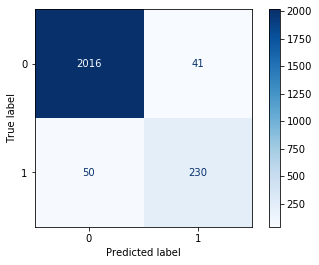

In [26]:
plot_confusion_matrix(model, X_val_encoded, y_val)

XGBClassifier의 Roc score값은 다음과 같습니다.

ROC-AUC: 0.9895921591777208 

ValiueError 로 인하여 타겟값 맵핑을 완료하였습니다.
 Not Specified = 0, good = 1 

ROC-AUC값을 다시 한 번 출력합니다 : 0.9895921591777208 



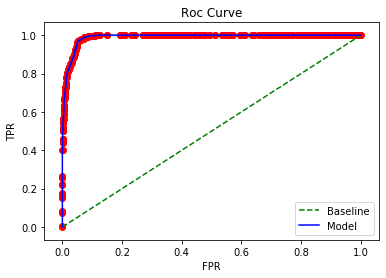

,fpr,tpr,thresholds
0,0.000000,0.000000,1.998249
1,0.000000,0.003571,0.998249
2,0.000000,0.075000,0.989301
3,0.000000,0.082143,0.989130
4,0.000000,0.153571,0.985590
...,...,...,...
452,0.994166,1.000000,0.000040
453,0.995625,1.000000,0.000040
454,0.996597,1.000000,0.000037
455,0.997569,1.000000,0.000035


In [27]:
get_roc_auc(model, X_val_encoded, y_val)

#### 3-2. `XGBClassifier` : 불균형 데이터에 가중치를 생각한 경우 


In [28]:
# 모델 생성.
model = XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'auc',
    n_estimators = 987654321,
    random_state = 42,
    n_jobs = -1,
    max_depth = 5,
    learning_rate = 0.1,
    early_stopping_rounds = 50,
    
    # 불균형 타겟 값에 가중치를 부여하는 parameter = scale_pos_weight
    scale_pos_weight=(y_val_encoded == 0).sum() / (y_val_encoded == 1).sum()
) 

# early_stoping으로 적용될 함수
watchlist = [(X_train_encoded, y_train_encoded), (X_val_encoded, y_val_encoded)]


# fit
model.fit(
    X_train_encoded,
    y_train_encoded,
    eval_set = watchlist)

[0]	validation_0-auc:0.97422	validation_1-auc:0.97449
[1]	validation_0-auc:0.97449	validation_1-auc:0.97582
[2]	validation_0-auc:0.98120	validation_1-auc:0.97936
[3]	validation_0-auc:0.98271	validation_1-auc:0.98082
[4]	validation_0-auc:0.98237	validation_1-auc:0.98038
[5]	validation_0-auc:0.98331	validation_1-auc:0.98129
[6]	validation_0-auc:0.98312	validation_1-auc:0.98109
[7]	validation_0-auc:0.98326	validation_1-auc:0.98175
[8]	validation_0-auc:0.98343	validation_1-auc:0.98207
[9]	validation_0-auc:0.98371	validation_1-auc:0.98193
[10]	validation_0-auc:0.98404	validation_1-auc:0.98255
[11]	validation_0-auc:0.98403	validation_1-auc:0.98266
[12]	validation_0-auc:0.98453	validation_1-auc:0.98364
[13]	validation_0-auc:0.98499	validation_1-auc:0.98404
[14]	validation_0-auc:0.98526	validation_1-auc:0.98435
[15]	validation_0-auc:0.98567	validation_1-auc:0.98478
[16]	validation_0-auc:0.98596	validation_1-auc:0.98511
[17]	validation_0-auc:0.98615	validation_1-auc:0.98527
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=987654321, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

불균형한 클래스에 대하여 가중치를 적용한 'model'의 정확도는 다음과 같습니다.

In [29]:
score(model)

model의 best_iteration: 87

검증데이터를 통한 모델의 정확도 : 0.9456568249893025
검증 AUC : 0.9506180984790612


best_iteration 및 Accuracy 모두 낮아진 것을 확인할 수 있습니다. <br/>
모델이 어떻게 데이터를 분류하였는지 `confusion_matrix` 및 `report`를 한 번 확인하여 봅니다.

결과 내용을 한눈에 볼 수 있는 함수를 생성하여 봅시다.

In [30]:
def summarize_results(model, X_val_encoded, y_val):

  # 1-1. 검증 정확도 : 기존에 만들어 놓은 함수를 사용.
  score(model)

    # 타겟 데이터 type 변환
  print(f'타겟 :TypeError 가 생기기 때문에 변환을 시도합니다.')    
  y_val_encoded_mapped = y_val.replace(['Not Specified', 'good'], [0,1])
  print(f'타겟 변경 완료 : {y_val_encoded_mapped.unique()}(Not Specified => 0,  good=> 1)\n')

  # 1-2.  classification report 생성.
  if isinstance(model, XGBClassifier):

    y_pred = model.predict(X_val_encoded, 
                          iteration_range = (0, model.best_iteration))

    print(classification_report(y_val_encoded_mapped, y_pred))

  else:
    y_pred = model.predict(X_val_encoded)
    print(classification_report(y_val_encoded_mapped, y_pred))
 
  # -------------------------------------------

  # 2. train & val loss Plot
  if isinstance(model, XGBClassifier):
    results = model.evals_result()
    
    # key : 'auc' 입니다.
    tgts = results['validation_0'].keys()

    for tgt in tgts:
      # train의 error 값을 리스트로 불러옵니다.
      train_error = results['validation_0'][tgt]

      # val의 error 값을 리스트로 불러옵니다.
      val_error = results['validation_1'][tgt]

      # train plot 생성.
      plt.plot(train_error, label = 'Train')
      
      # val plot 생성.
      plt.plot(val_error, label = 'val')
      plt.ylabel(tgt)
      plt.xlabel("Model Complexity (n_estimators)")
      plt.axvline(x = model.best_iteration, color = 'r', linestyle = '-', linewidth = 2)
      plt.text(model.best_iteration, 0.98, 'best_iteration')
      plt.legend()
      plt.show()
    
    # 3.ROC-AUC Curve
    get_roc_auc(model, X_val_encoded, y_val)

    print('\n')
    # 4.Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_val_encoded,y_val_encoded_mapped, cmap = 'Blues')
    
    
    plt.suptitle(f'Confusion matrix n={len(y_val)}', fontsize = 15, y = 1)
    plt.title(f'Not_specified : {y_val.value_counts()[0]}, good : {y_val.value_counts()[1]}', fontsize =10, pad = 10)

    plt.show()

model의 best_iteration: 87

검증데이터를 통한 모델의 정확도 : 0.9456568249893025
검증 AUC : 0.9506180984790612
타겟 :TypeError 가 생기기 때문에 변환을 시도합니다.
타겟 변경 완료 : [0 1](Not Specified => 0,  good=> 1)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2057
           1       0.70      0.96      0.81       280

    accuracy                           0.95      2337
   macro avg       0.85      0.95      0.89      2337
weighted avg       0.96      0.95      0.95      2337



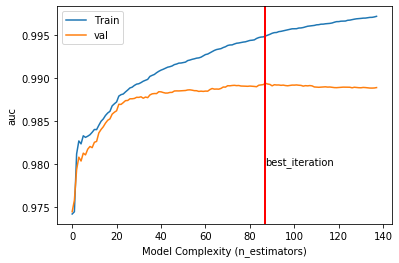

ROC-AUC: 0.9892518577679006 

ValiueError 로 인하여 타겟값 맵핑을 완료하였습니다.
 Not Specified = 0, good = 1 

ROC-AUC값을 다시 한 번 출력합니다 : 0.9892518577679006 



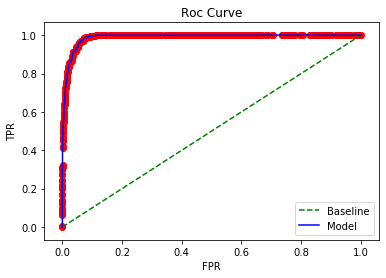

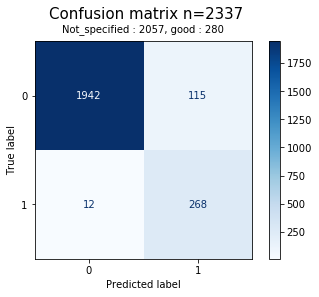

In [31]:
summarize_results(model, X_val_encoded, y_val)

#### 3-3. Insight : 가중치를 적용한 모델 vs 그렇지 않은 모델

* 가중치를 적용한 모델의 정확도는 그렇지 않은 모델과 0.04 낮습니다.
  * 성능이 떨어졌다고 말할 수는 없을 것 같습니다, <br/> 
  0-class 에 대한 정확도를 다소 희생하였으나 1-class에 대한 정확도를 크게 향상시켰습니다.

#### 3-4. 불균형을 해결하기 위한 방법들 중, 한 가지를 더 사용하여 봅시다.
> **Oversampling + Undersampling** : 기존의 단점을 상쇄시키는 방법

❗ 새로운 데이터를 Oversampling으로 합성한 후, 생성된 데이터들 중 노이즈가 큰 데이터들을 Undersampling으로 정리하는 방법이 존재합니다.

* `Oversampling` 소수 클래스의 기존 데이터들과 유사한 합성 데이터를 만들어서 수를 늘리는 방식이다.
  * 단점 : 기존 데이터를 기반으로 새로운 데이터를 합성하기 때문에, 생성된 합성 데이터들이 noisy하다는 문제가 존재합니다.


* `Undersampling`은 두 클래스의 비율을 동일하게 맞춰주는 강력한 방법입니다.
  * 단점 : 다수 클래스의 데이터에서 많은 손실이 일어난다는 단점이 존재합니다.


In [32]:
from imblearn.combine import SMOTEENN

X_train_sampled, y_train_sampled = SMOTEENN(random_state = 42).fit_resample(X_train_encoded, y_train_encoded)

model = XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'auc',
    n_estimators = 987654321,
    random_state = 42,
    n_jobs = -1,
    max_depth = 5,
    learning_rate = 0.1,
    early_stopping_rounds = 50,
    scale_pos_weight=(y_train_sampled == 0).sum() / (y_train_sampled == 1).sum()
)



동일한 비율은 아니지만, `class ; 1`의 데이터가 생성되었습니다.

In [33]:
y_train_sampled.value_counts()

1    4984
0    4633
Name: good_badge, dtype: int64

In [34]:
watchlist = [(X_train_sampled, y_train_sampled),(X_val_encoded, y_val_encoded)]

model.fit(
    X_train_sampled,
    y_train_sampled,
    eval_set = watchlist)

[0]	validation_0-auc:0.98609	validation_1-auc:0.93984
[1]	validation_0-auc:0.99300	validation_1-auc:0.96234
[2]	validation_0-auc:0.99349	validation_1-auc:0.96139
[3]	validation_0-auc:0.99269	validation_1-auc:0.96074
[4]	validation_0-auc:0.99432	validation_1-auc:0.96377
[5]	validation_0-auc:0.99423	validation_1-auc:0.96441
[6]	validation_0-auc:0.99417	validation_1-auc:0.96388
[7]	validation_0-auc:0.99423	validation_1-auc:0.96435
[8]	validation_0-auc:0.99579	validation_1-auc:0.96846
[9]	validation_0-auc:0.99624	validation_1-auc:0.97146
[10]	validation_0-auc:0.99648	validation_1-auc:0.97283
[11]	validation_0-auc:0.99665	validation_1-auc:0.97395
[12]	validation_0-auc:0.99674	validation_1-auc:0.97453
[13]	validation_0-auc:0.99692	validation_1-auc:0.97607
[14]	validation_0-auc:0.99699	validation_1-auc:0.97657
[15]	validation_0-auc:0.99708	validation_1-auc:0.97684
[16]	validation_0-auc:0.99708	validation_1-auc:0.97725
[17]	validation_0-auc:0.99741	validation_1-auc:0.97904
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=987654321, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [35]:
model.best_iteration

109

model의 best_iteration: 109

검증데이터를 통한 모델의 정확도 : 0.9443731279418057
검증 AUC : 0.9234208972845335
타겟 :TypeError 가 생기기 때문에 변환을 시도합니다.
타겟 변경 완료 : [0 1](Not Specified => 0,  good=> 1)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2057
           1       0.71      0.90      0.79       280

    accuracy                           0.94      2337
   macro avg       0.85      0.92      0.88      2337
weighted avg       0.95      0.94      0.95      2337



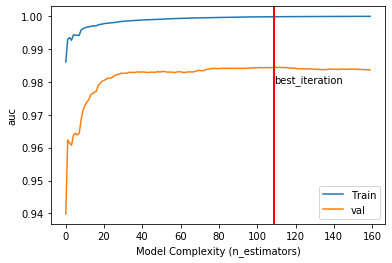

ROC-AUC: 0.9843860684769776 

ValiueError 로 인하여 타겟값 맵핑을 완료하였습니다.
 Not Specified = 0, good = 1 

ROC-AUC값을 다시 한 번 출력합니다 : 0.9843860684769776 



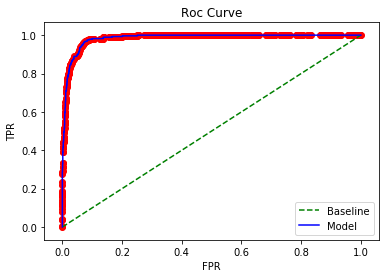

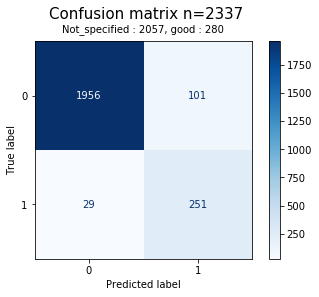

In [36]:
summarize_results(model, X_val_encoded, y_val)

**INSIGHT : Oversampling & Undersampling**
> 가중치를 적용했던 두번째 모델과 비교하였을 때.

* 두 가지 샘플링을 적용한 모델의 경우, `class:1`의 재현율이 하락하였습니다.
  * 또한 f1-score가 소폭 하락하였으며, Roc-auc score 및 모델의 정확도 또한 소폭 하락하였습니다. <br/>

❗ XGBClassifier의 모델에 대하여 하이퍼파라미터 튜닝을 진행하여 봅시다.  

#### 3-5. 하이퍼 파라미터 튜닝.
> 파이프라인 모델을 구성합니다.

* 또한 탐색할 하이퍼파라미터 범위를 지정하여 줍시다.

In [37]:
pipe = make_pipeline(
    XGBClassifier(
        objective = 'binary:logistic',
       # early_stopping_rounds =20, 
        eval_metric = 'error',
        n_estimators = 200,
        random_state = 42,
        n_jobs = -1, 
        learning_rate = 0.1,
    )
)

print(pipe)

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='error',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=-1

하이퍼파라미터 범위 지정은 다음과 같이 진행합니다.

In [38]:
y_train.value_counts()

Not Specified    6169
good              839
Name: good_badge, dtype: int64

In [39]:
# 불균형 데이터의 가중치 값은 보통 아래와 같이 진행됩니다.
# 아래의 값은 7.35입니다, 비슷한 값을 포함하여 하이퍼파라미터로 지정합니다.
scale_pos_weight=(y_train_sampled == 0).sum() / (y_train_sampled == 1).sum(),

watchlist = [(X_train, y_train), (X_val, y_val)]


params = {
    "xgbclassifier__max_depth": [2, 4, 5, 6],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__colsample_bytree": [0.6, 0.8, 1.0],
    'xgbclassifier__scale_pos_weight': [5.35, 6.35, 7.35]
}


#fit_params = {'xgbclassifier__eval_set': [(X_train_encoded, y_train_encoded), (X_val_encoded, y_val_encoded)]}

fitting 진행 : Exhaustive Grid Search 진행.
각 파라미터 조합 $4 \times 3 \times 3 \times 3$ 에 (cv 값 :3) 을 곱하여 324번의 fitting이 진행됩니다.

In [40]:
# 필요한 라이브러리를 가져옵니다.
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, param_grid = params, scoring = 'roc_auc', cv = 3, verbose =3)
grid_search.fit(X_train_encoded, y_train_encoded) #**fit_params)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2, xgbclassifier__scale_pos_weight=5.35;, score=0.985 total time=   0.2s
[CV 2/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2, xgbclassifier__scale_pos_weight=5.35;, score=0.984 total time=   0.3s
[CV 3/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2, xgbclassifier__scale_pos_weight=5.35;, score=0.988 total time=   0.2s
[CV 1/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2, xgbclassifier__scale_pos_weight=6.35;, score=0.985 total time=   0.2s
[CV 2/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2, xgbclassifier__scale_pos_weight=6.35;, score=0.984 total time=   0.2s
[CV 3/3] END xgbclassi

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='error',
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                     

GridSearch로 찾은 최적의 파라미터를 나열합니다.

In [41]:
print('최적 하이퍼파라미터', grid_search.best_params_)
print('최적 AUC', grid_search.best_score_)

최적 하이퍼파라미터 {'xgbclassifier__colsample_bytree': 0.6, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__scale_pos_weight': 5.35}
최적 AUC 0.9878301319465237


각 하이퍼 파라미터 조합으로 만들어진 모델들을 순위별로 나열해봅니다.
* rank_test_score : 테스트 순위
* mean_score_time : 예측에 걸리는 시간.

In [42]:
pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').T

,9,82,45,11,81,10,49,18,47,46,...,73,43,8,44,80,78,79,7,42,6
mean_fit_time,2.360484,0.531038,1.455973,0.399663,0.550888,0.482547,0.44887,0.471614,0.456926,0.457845,...,0.317027,0.259026,2.342569,0.292584,0.299152,0.301295,0.302941,1.450905,0.258818,1.44044
std_fit_time,0.067698,0.001256,1.417327,0.008609,0.018876,0.139586,0.008529,0.004057,0.00087,0.002928,...,0.016277,0.007716,1.464121,0.04199,0.001319,0.006775,0.007972,0.338804,0.002437,0.299048
mean_score_time,0.030521,0.008901,0.009024,0.008962,0.008879,0.009083,0.009106,0.011131,0.00966,0.009072,...,0.007324,0.006866,0.02134,0.011042,0.006967,0.00686,0.006914,0.01772,0.006958,0.02233
std_score_time,0.018239,0.000145,0.000055,0.000108,0.000028,0.00017,0.000119,0.001253,0.000832,0.000245,...,0.000662,0.000131,0.004422,0.005846,0.000104,0.000162,0.000078,0.004946,0.000348,0.011561
param_xgbclassifier__colsample_bytree,0.6,1.0,0.8,0.6,1.0,0.6,0.8,0.6,0.8,0.8,...,1.0,0.8,0.6,0.8,1.0,1.0,1.0,0.6,0.8,0.6
param_xgbclassifier__max_depth,4,4,4,4,4,4,4,5,4,4,...,2,2,2,2,2,2,2,2,2,2
param_xgbclassifier__min_child_weight,2,2,2,2,2,2,4,2,2,2,...,2,8,8,8,8,8,8,8,8,8
param_xgbclassifier__scale_pos_weight,5.35,6.35,5.35,7.35,5.35,6.35,6.35,5.35,7.35,6.35,...,6.35,6.35,7.35,7.35,7.35,5.35,6.35,6.35,5.35,5.35
params,"{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...",...,"{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc..."
split0_test_score,0.987738,0.987659,0.987589,0.987633,0.987635,0.987475,0.987078,0.987517,0.987646,0.987483,...,0.984861,0.983471,0.983736,0.983158,0.9838,0.982176,0.982799,0.982247,0.982032,0.981478


> GridSearchCV로 찾아낸 최적의 파라미터를 적용하여 모델을 다시 생성합니다.

* 다음과 같은 하이퍼 파라미터값을 찾아냈습니다.
  * `'xgbclassifier__colsample_bytree': 0.6,` 
  * `'xgbclassifier__max_depth': 4, `
  * `'xgbclassifier__min_child_weight': 2, `
  * `'xgbclassifier__scale_pos_weight': 5.35`


In [43]:
pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(
        objective = 'binary:logistic',
        eval_metric = 'error',
        n_estimators = 200,
        random_state = 42,
        learning_rate = 0.1,
        n_jobs = -1,
        colsample_bytree = 0.6,
        max_depth = 4,
        min_child_weight = 2,
        scale_pos_weight = 5.35,
        early_stopping_rounds = 20
    )
)

print(pipe)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, early_stopping_rounds=20,
                               enable_categorical=False, eval_metric='error',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=-1,
               

In [44]:
# early_stopping_rounds 를 적용시키기 위하여 위에서 정의한 fit_params을 이용합니다.
fit_params = {'xgbclassifier__eval_set': [(X_train_encoded, y_train_encoded), (X_val_encoded, y_val_encoded)]}

pipe.fit(X_train, y_train_encoded, **fit_params)

[0]	validation_0-error:0.17551	validation_1-error:0.16774
[1]	validation_0-error:0.10702	validation_1-error:0.10526
[2]	validation_0-error:0.09189	validation_1-error:0.09157
[3]	validation_0-error:0.10802	validation_1-error:0.10997
[4]	validation_0-error:0.10160	validation_1-error:0.10312
[5]	validation_0-error:0.09974	validation_1-error:0.10141
[6]	validation_0-error:0.08747	validation_1-error:0.08558
[7]	validation_0-error:0.09889	validation_1-error:0.10141
[8]	validation_0-error:0.08947	validation_1-error:0.08943
[9]	validation_0-error:0.08776	validation_1-error:0.08686
[10]	validation_0-error:0.09717	validation_1-error:0.09499
[11]	validation_0-error:0.09147	validation_1-error:0.08558
[12]	validation_0-error:0.07848	validation_1-error:0.07702
[13]	validation_0-error:0.07520	validation_1-error:0.07274
[14]	validation_0-error:0.07549	validation_1-error:0.07103
[15]	validation_0-error:0.07549	validation_1-error:0.07060
[16]	validation_0-error:0.07962	validation_1-error:0.07531
[17]	va

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['model', 'transmission', 'fuelType',
                                      'size', 'type'],
                                mapping=[{'col': 'model',
                                          'data_type': dtype('O'),
                                          'mapping': A7      1
A3      2
A5      3
Q3      4
Q2      5
A1      6
Q5      7
A8      8
Q7      9
A4     10
A6     11
TT     12
Q8     13
RS3    14
S3     15
S8     16
RS4    17
RS6    18
RS5    19
R8     20
SQ5    21
S4     22
SQ7    23
S5     24
NaN    -2
dtype: int64},
                                         {'col': 'transmission',
                                          'data_type': dtype('O'),
                                          'mapping': Automatic    1
Semi-Auto    2
Man...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                     

In [45]:
pipe.named_steps['xgbclassifier'].best_iteration

137

model의 best_iteration: 137

검증데이터를 통한 모델의 정확도 : 0.9525032092426188
검증 AUC : 0.9588921105632335
타겟 :TypeError 가 생기기 때문에 변환을 시도합니다.
타겟 변경 완료 : [0 1](Not Specified => 0,  good=> 1)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2057
           1       0.72      0.97      0.83       280

    accuracy                           0.95      2337
   macro avg       0.86      0.96      0.90      2337
weighted avg       0.96      0.95      0.95      2337



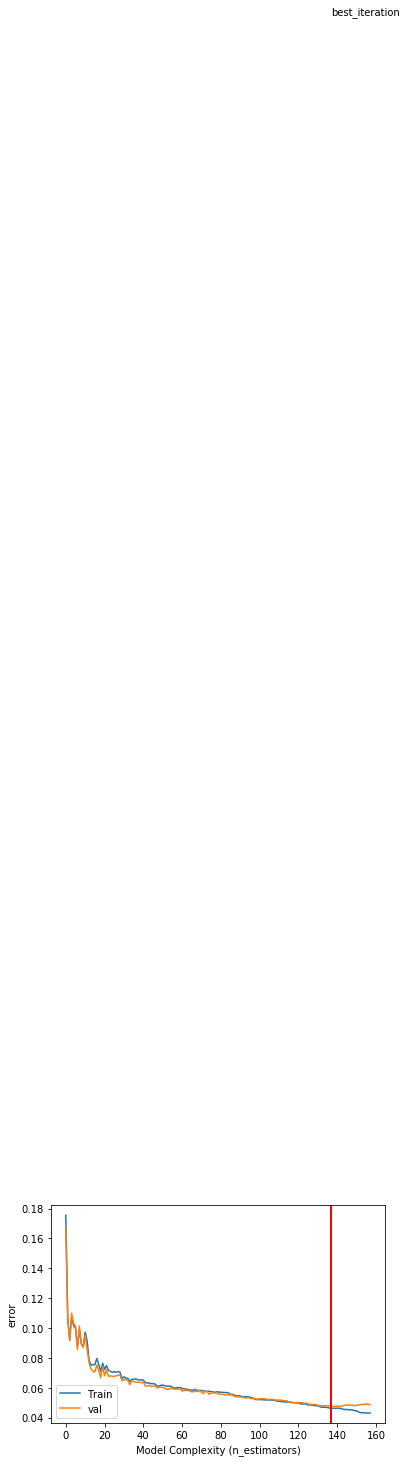

ROC-AUC: 0.9892440447253281 



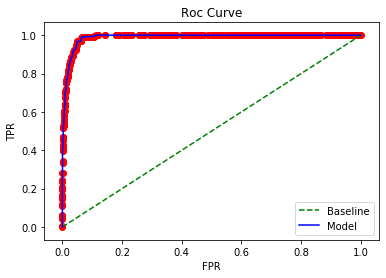

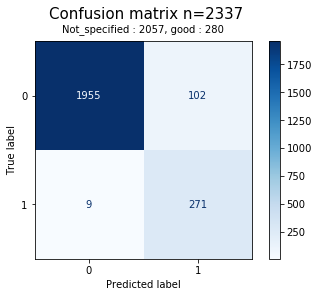

In [46]:
summarize_results(pipe.named_steps['xgbclassifier'], X_val_encoded, y_val_encoded)

**INSIGHT : GridSearch**

* 하이퍼 파라미터로 수치를 조정한 결과, 이전보다 `class :1` 를 더 많이 가려냈습니다.
  * 특이점으로는 `class:1`의 f1-score는 같지만, `precision`는 10%가량 크게 하락 하락하였으나, <br/> `recall` 값은 10%이상 크게 향상되었습니다.
  * (Recall과 Precision은 확실히 `Trade-Off` 관계라는 것을 다시 한 번 확인할 수 있었습니다.)

#### 제 관점에서는 이러한 모델이 좋을 것 같습니다.🤔
* 상태가 좋지 않은 차량에 badge를 붙이는 건, 사고등의 위험을 초래할 수 있습니다.
* 판매하는 입장에서, `Recall :재현율 (모델이 잘 예측한 클래스의 비율)` 높으면 많은 차량을 판매할 수 있습니다.<br/>
 **하지만, 잘못된 차량에 뱃지를 붙여 판매할 수 있을 확률이 높아지므로 주의를 요합니다❗**
  
  * 결론적으로 좋은 상태의 차량을 예측하는 `Precision : 정밀도`가 높아야 한다고 생각됩니다.

#4. Feature Importance (PI)


####4-1. Permutation Importance
> 모델을 재학습시키지 않고, 기존 모델에서 각 특성에 노이즈를 줍니다.

* 모델이 해당 특성을 의사결정에 사용하지 못하게 만들었을 때, 성능이 얼마나 감소하는지 확인합니다.
  * 이때, 노이즈를 주는 가장 간단한 방법이 그 특성값들을 샘플내에서 섞는 것(shuffle, Permutation) 입니다.

**장점**
 * 재학습이 필요없다.
 * 모든 모델에 범용적으로 적용이 가능한 방법입니다.
 * Feature Importance(MDI) 보다 high cardinality 특성에 덜 치우친 결과를 나타냅니다. <br/>

**단점**
* 강한 상관관계가 존재하는 특성들이 존재할 때, 잘못된 값을 낼 수 있습니다.

  1. 상관관계가 있는 두 특성중 하나의 값에 노이즈를 주게 되면, 모델의 결과가 비현실적인 데이터로 도출될 수 있습니다. <br/>
  ex) 키와 몸무게의 경우 :  2m & 30kg.

  2. 하나의 값에 노이즈를 주어도 해당 정보를 다른 특성으로부터 얻을 수도 있고, 
  성능은 크게 하락하지 않을 수도 있습니다.
  결과적으로, 섞인 특성(해당 특성과 강력한 관계가 있는 특성 모두)은 실제로 중요한 특성일 수 있음에도, 낮은 PI를 보이게 됩니다.

    * 결과적으로 섞인 특성(해당 특성과 강력한 관계가 있는 특성 모두)은 실제로 중요한 특성일 수 있음에도 낮은 PI를 보이게 됩니다.



**`eli5`** 라이브러를 사용하여 `Permutation Importance`를 계산합니다.

In [47]:
#필요한 라이브러리를 가져옵니다.

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['xgbclassifier'], # model
    scoring = 'accuracy', # metric
    n_iter = 10,
    random_state = 42)


# 스코어를 계산합니다.
permuter.fit(X_val_encoded,y_val_encoded)


PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.6,
                                              early_stopping_rounds=20,
                                              enable_categorical=False,
                                              eval_metric='error',
                                              feature_types=None, gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.1, max_bin=256,
                       

`Permutation Importance`의 시각화는 다음과 같습니다.

Text(0.5, 1.0, 'Permutation Importance')

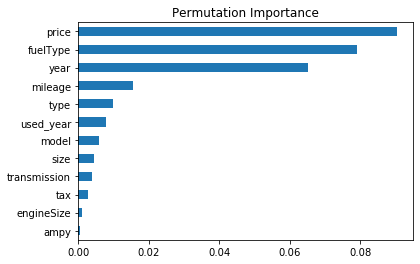

In [48]:
# 계산된 PI값을 시각화로 살펴봅니다.
feature_names = X_val.columns.tolist()

# 시리즈로 생성합니다.
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title('Permutation Importance')

특성별 점수는 다음과 같습니다.

In [49]:
eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names,
)

Weight,Feature
0.0904 ± 0.0071,price
0.0791 ± 0.0061,fuelType
0.0651 ± 0.0101,year
0.0155 ± 0.0065,mileage
0.0098 ± 0.0043,type
0.0077 ± 0.0053,used_year
0.0059 ± 0.0059,model
0.0046 ± 0.0016,size
0.0039 ± 0.0016,transmission
0.0027 ± 0.0021,tax


# 5. Individual Conditional Expectation(ICE) plot

> 특정 관측치에 대하여 특정 특성값을 변화시킬 때, 모델의 예측양상이 어떻게 변하는지 파악할 수 있습니다.

* 즉, ICE plot을 사용하면, 특정 관측치(데이터 포인트)에서의 특정 특성 변화에 따른 모델의 예측 양상 변화를 확인할 수 있습니다.

* Feature importance의 경우, 각 특성이 예측 성능에 얼마나 영향을 주는지 쉽게 파악할 수 있으나, <br/>
  **각 특성이 증가/감소 할 때 모델에 어떠한 영향을 주는지 알 수 없습니다..**

In [50]:
X_val.iloc[[3]]

,model,year,price,transmission,mileage,fuelType,tax,engineSize,size,type,used_year,ampy
248,Q5,2019,37985,Automatic,10,Diesel,145,2.0,mid,suv,4,2.5


예측 양상의 변화를 확인하고자 하는 데이터는 위의 내용과 같습니다. <br/>
**차량의 연식이 바뀔수록 모델이 어떻게 예측을 달리하는지 확인하여 봅시다.**


In [51]:
# 변화를 확인하고자 하는 데이터를 복사합니다.
one_datapoint = X_val_encoded.iloc[[3]].copy()

# 세 번째 데이터의 컬럼 `year`를 데이터셋에 존재하는 연도(최대 및 최소)로 바꿔줍시다.
year_test_range = range(X_val_encoded['year'].min(), X_val_encoded['year'].max()+1)

# 빈 리스트 생성.
results = []


# 오래된 연도에서, 가장 최근 연도까지 진행합니다.
for year in year_test_range:
  one_datapoint['year'] = year

  # year값이 변경되며 예상되는 확률 /numpy.ndarray 타입
  one_datapoint_pred_proba = pipe.named_steps['xgbclassifier'].predict_proba(one_datapoint)[:,1] 

  # item()으로 인해 '값:소수'만 추가됩니다  
  results.append(one_datapoint_pred_proba.item()) 

#numpy.ndarray으로 변환됩니다.
results = np.array(results)

# 가장 오래된 연식일 때, 모델 예측 확률로부터의 변화값을 살펴봅니다.
results -= results[0] 

Text(0, 0.5, '$\\Delta$ pred_proba')

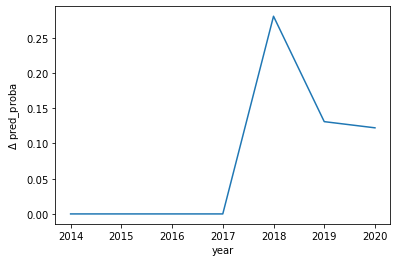

In [52]:
# 시각화를 진행합니다.
plt.plot(year_test_range, results)

plt.xlabel('year')
plt.ylabel("$\Delta$ pred_proba")

차량모델 'Q5'는 2014~2017년에 출고된 차량은 뱃지를 받을 확률이 적었습니다.<br/> 2018년의 모델이 뱃지를 받을 확률이 가장 높으며 2019년 형은 10% 감소, 2020년 형은 소폭 감소하였습니다.  

🔔 다른 특성을 갖고 있는 차량 또한 위와 같이 분석하는지 확인하여 봅시다. 

In [53]:
from xgboost.sklearn import XGBRFClassifier
# 원하는 피처의 해당 범위내의 값을 변경시, 모델의 예측 양상의 변화를 확인하는 함수를 작성합니다.
def get_ice_plot_data(model,data, data_index, target_feature, target_feature_range):

  # 살펴볼 데이터를 복사합니다.
  one_data_point = data.iloc[[data_index]].copy()

  # 결과를 담을 빈 리스트를 생성합니다.
  results = []

  # 해당 타겟의 범위로부터 타겟값을 변경합니다. (for문)
  for target_value in target_feature_range:

    # 해당 타겟 값은 target_value 값으로 변경됩니다.
    one_data_point[target_feature] = target_value
    
    # 생성한 모델이 xgbclassifier 인 경우
    if isinstance(model, XGBClassifier):
      one_data_point_pred_proba = model.predict_proba(one_data_point)[:,1]
      results.append(one_data_point_pred_proba.item())
    
    else :
      one_data_point_pred_proba = model.named_steps['xgbclassifier'].predict_proba(one_data_point)[:,1]
      results.append(one_data_point_pred_proba.item())
    
  results = np.array(results)
  return target_feature_range, results - results[0]


임의의 여러개 데이터(행)을 지정하고, 예측 확률로부터의 변화값을 시각화합니다.
* 모델은 다른차량이면 좋겠습니다.

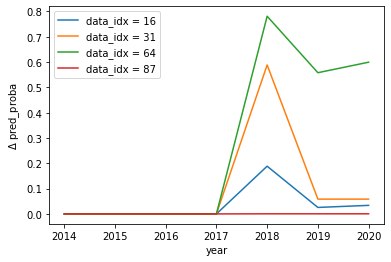

In [54]:
# 생성한 함수를 이용하여 데이터를 시각화합니다. 16, 31, 64, 87행을 살펴봅니다.

# 살펴볼 피처 지정 : year
target_feature = 'year'

target_feature_range = range(X_val_encoded['year'].min(), X_val_encoded['year'].max()+1)


# 살펴볼 데이터(행)는 다음과 같습니다. 16, 31, 64, 87
for data_index in [16, 31, 64, 87]:
  plt.plot(*get_ice_plot_data(
      pipe, X_val_encoded, data_index, target_feature, target_feature_range),
      label = f'data_idx = {data_index}')

plt.xlabel(target_feature)
plt.ylabel("$\Delta$ pred_proba")
plt.legend()

In [55]:
X_val.iloc[[87]]

,model,year,price,transmission,mileage,fuelType,tax,engineSize,size,type,used_year,ampy
258,RS6,2015,46000,Semi-Auto,20982,Petrol,325,4.0,subfull,wagon,8,2622.8


> 차량의 연도가 달라지면, 모델은 뱃지를 받을 수 있는 차량에 대한 연도의 영향력을 각기 다르게 평가합니다. 

* 특이점이 존재합니다. `87번 행: (차량)RS6` 은  차량의 연식에 관계없이 일정한 값을 유지하고 있습니다.
  * 차량의 값이 크게 유지되는 경우, 주로 고가의 차량이 가격방어가 비교적 높기에 출고가가 높은 차임을 유추할 수 있다.

#### 5-2. Partial Dependence Plot (PDP)

* ICE plot을 사용하면, 특정 데이터에 대하여 특성의 변화에 따른 모델의 예측 양상 변화를 살펴볼 수 있었습니다.
* 하지만, 하나의 ICE plot을 그려본 후, 모델이 해당 특성에 대하여 전반적으로 어떻게 분석하고 이해하고 있는지 판단할 수 없습니다.
  * 위에서도 본 것과 같이 다른 특성을 가진 차량에 대하여 모델은 `year` 특성의 영향력을 다르게 평가합니다. 

**PDP를 사용한다면 <u>해당 특성에 대하여 모델의 전반적인 이해방식을 살펴볼 수 있습니다</u>❗**
  * PDP는 입력 데이터들에 대한 ICE plot의 평균으로 구할 수 있습니다.

In [56]:
# 진행률을 확인할 수 있는 라이브러리 입니다.
from tqdm import tqdm

target_feature = 'year'
target_feature_range = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# 결과값을 넣을 빈 리스트를 생성합니다.
all_ice_plot_data = []


# 지정한 범위를 이용하여 ICE plot 데이터를 계산합니다 / tqdm() 안에 진행률을 확인하고 싶은 것을 넣습니다.
for data_index in tqdm(range(len(X_val_encoded))):

  
  all_ice_plot_data.append(
      
      # 범위 값을 제외한 결과값만 리스트로 수집합니다.
      get_ice_plot_data(pipe, X_val_encoded, data_index, target_feature, target_feature_range)[1]
  )


100%|██████████| 2337/2337 [01:06<00:00, 35.24it/s]


(2337, 9)
(9,)


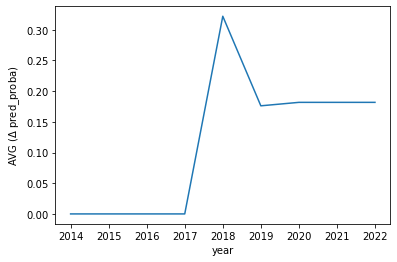

In [57]:
# 결과 값을 담은 리스트 데이터 타입을 변경합니다. -> numpy.adarray
all_ice_plot_data = np.array(all_ice_plot_data)
print(all_ice_plot_data.shape)

# 2337개의 Ice plot data를 0번째(data index) 축으로 평균합니다.
pdp_data = all_ice_plot_data.mean(0)
print(pdp_data.shape)

# PDP(평균 ICE Plot) data를 시각화하여 봅시다.
plt.plot(target_feature_range, pdp_data)
plt.xlabel(target_feature)
plt.ylabel('AVG ($\Delta$ pred_proba)')
plt.show()

> 모델은 평균적으로 2018년도의 차량이 배지를 받을 확률이 높다고 예측합니다.

* 이후의 연도는 뱃지를 받을 확률이 15% 정도 떨어집니다.



**PDP 사용시 주의점** ❗
**서로 강한 상관관계가 존재하는 컬럼에서는 비현실적인 데이터로 값을 예측**하게 됩니다.

* 우리가 알아보고자하는 변화량의 특성은 `year` 입니다. 이 특성은 `
used_year`과 큰 상관관계를 갖고 있습니다.

In [58]:
#pdpbox 라이브러리 오류로 matplotlib를 삭제후 재설치를 진행합니다.
!pip uninstall matplotlib
!pip install matplotlib

Found existing installation: matplotlib 3.1.1
Uninstalling matplotlib-3.1.1:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/matplotlib-3.1.1-py3.9-nspkg.pth
    /usr/local/lib/python3.9/dist-packages/matplotlib-3.1.1.dist-info/*
    /usr/local/lib/python3.9/dist-packages/matplotlib/*
    /usr/local/lib/python3.9/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.9/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.9/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.9/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.9/dist-packages/pylab.py
Proceed (Y/n)? n
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import matplotlib as mpl
import matplotlib.font_manager as fm



print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())

버전:  3.1.1
설치 위치:  /usr/local/lib/python3.9/dist-packages/matplotlib/__init__.py
설정 위치:  /root/.config/matplotlib
캐시 위치:  /root/.cache/matplotlib


In [60]:
print ('설정파일 위치: ', mpl.matplotlib_fname())


설정파일 위치:  /usr/local/lib/python3.9/dist-packages/matplotlib/mpl-data/matplotlibrc


In [61]:
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# ttf 폰트 전체갯수
print(len(font_list)) 

17


In [62]:
font_list

['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf',
 '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
 '/usr/share/fonts/truetype/liberat

In [63]:
f = [f.name for f in fm.fontManager.ttflist]
f[:10]

['STIXGeneral',
 'cmsy10',
 'STIXNonUnicode',
 'STIXSizeThreeSym',
 'STIXGeneral',
 'STIXSizeThreeSym',
 'STIXNonUnicode',
 'DejaVu Sans',
 'cmr10',
 'DejaVu Sans Mono']

In [68]:
plt.rcParams["font.family"] =  'DejaVu Sans.ttf'


(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb38d662880>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb38d649820>})

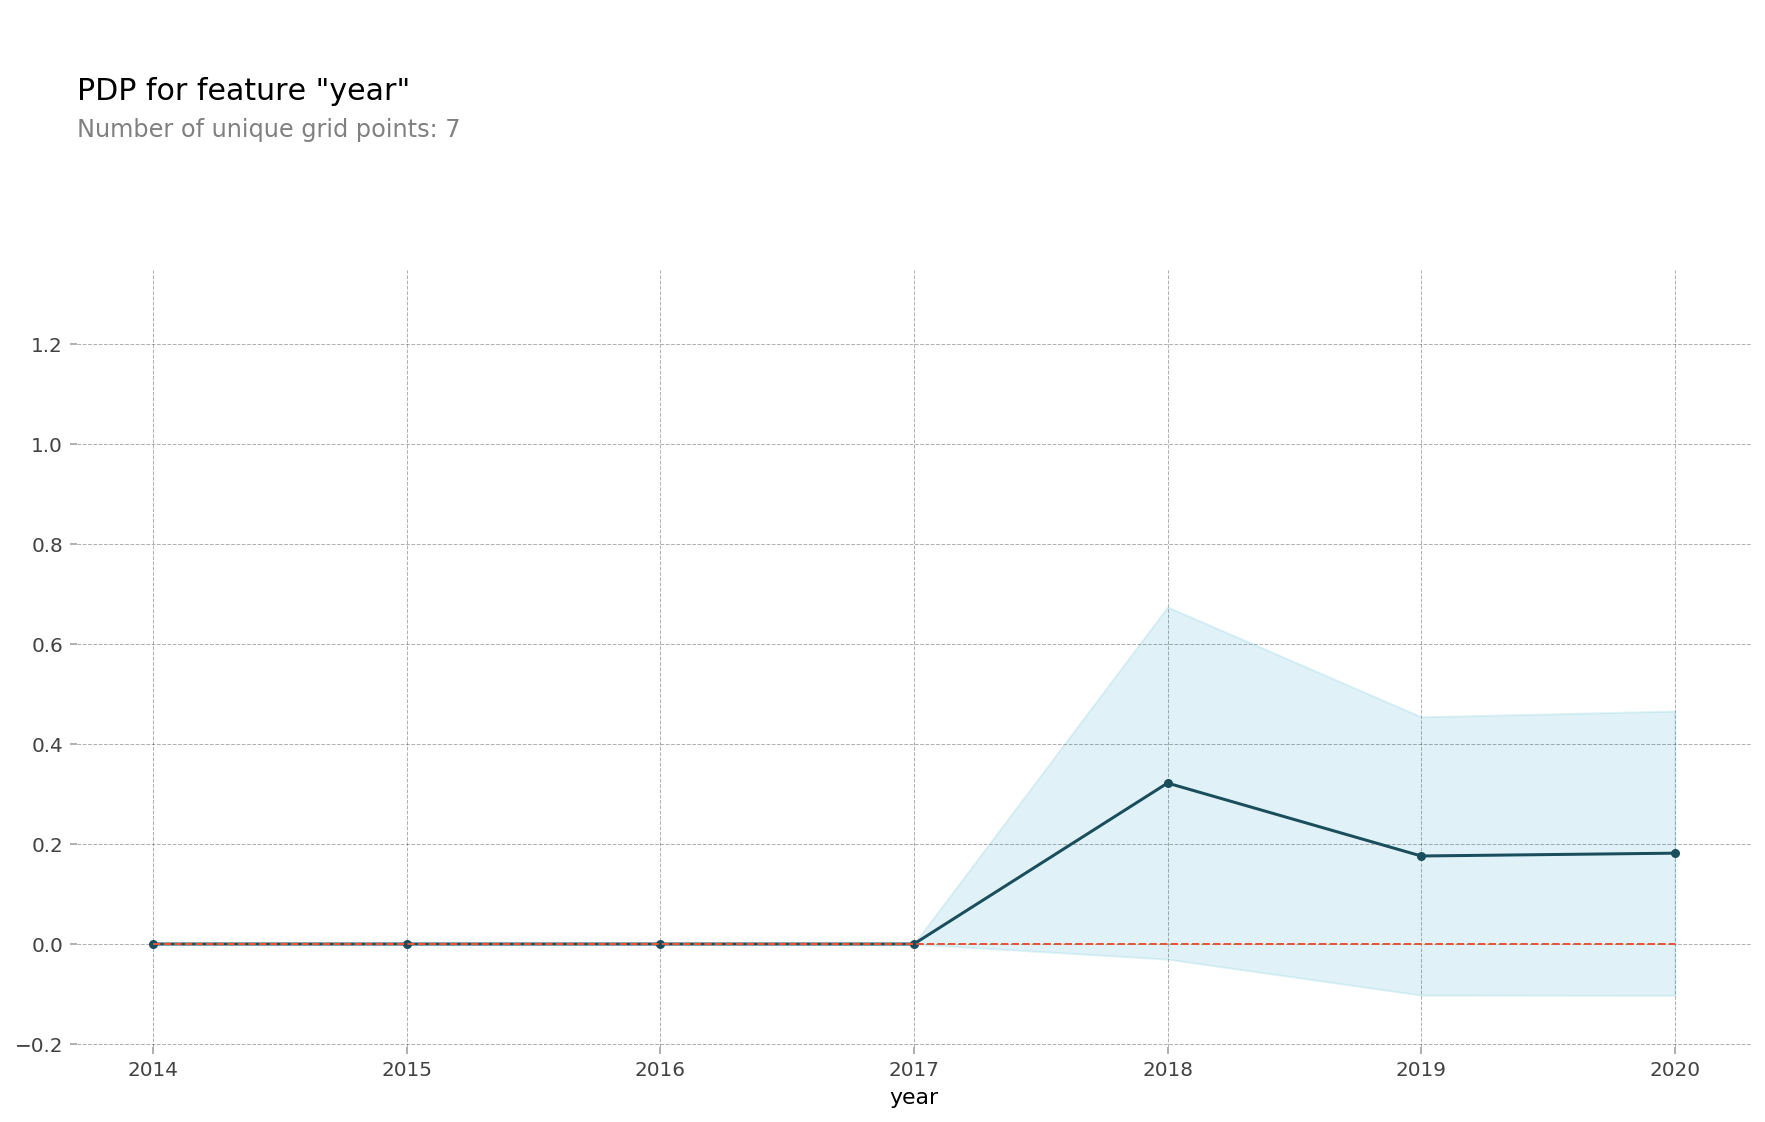

In [69]:
# 필요한 라이브러리를 가져옵니다,
import matplotlib.pyplot as plt 
from pdpbox.pdp import pdp_isolate, pdp_plot

#dpi(dots per inch) 수치를 조절하여 이미지 화질을 조정할 수 있다.
plt.rcParams["figure.dpi"] = 144

# 살펴볼 타겟피처를 지정합니다.
target_feature = 'year'

# pdpbox 라이브러리의 pdp_isolate를 사용한다면 하나의 특성에 대한 PDP를 시각화 할 수 있다.
isolated = pdp_isolate(
    model = pipe.named_steps['xgbclassifier'],
    dataset = X_val_encoded,
    model_features = X_val.columns,
    feature = target_feature,
    grid_type = 'percentile',
    num_grid_points = 10,
)

pdp_plot(isolated, feature_name = target_feature)

`pdp_plot`을 사용하여 PDP를 50개의 ICE plot과 함께 그려봅니다.

(<Figure size 2160x1368 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb387af0640>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb387a9c310>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb387a46730>}})

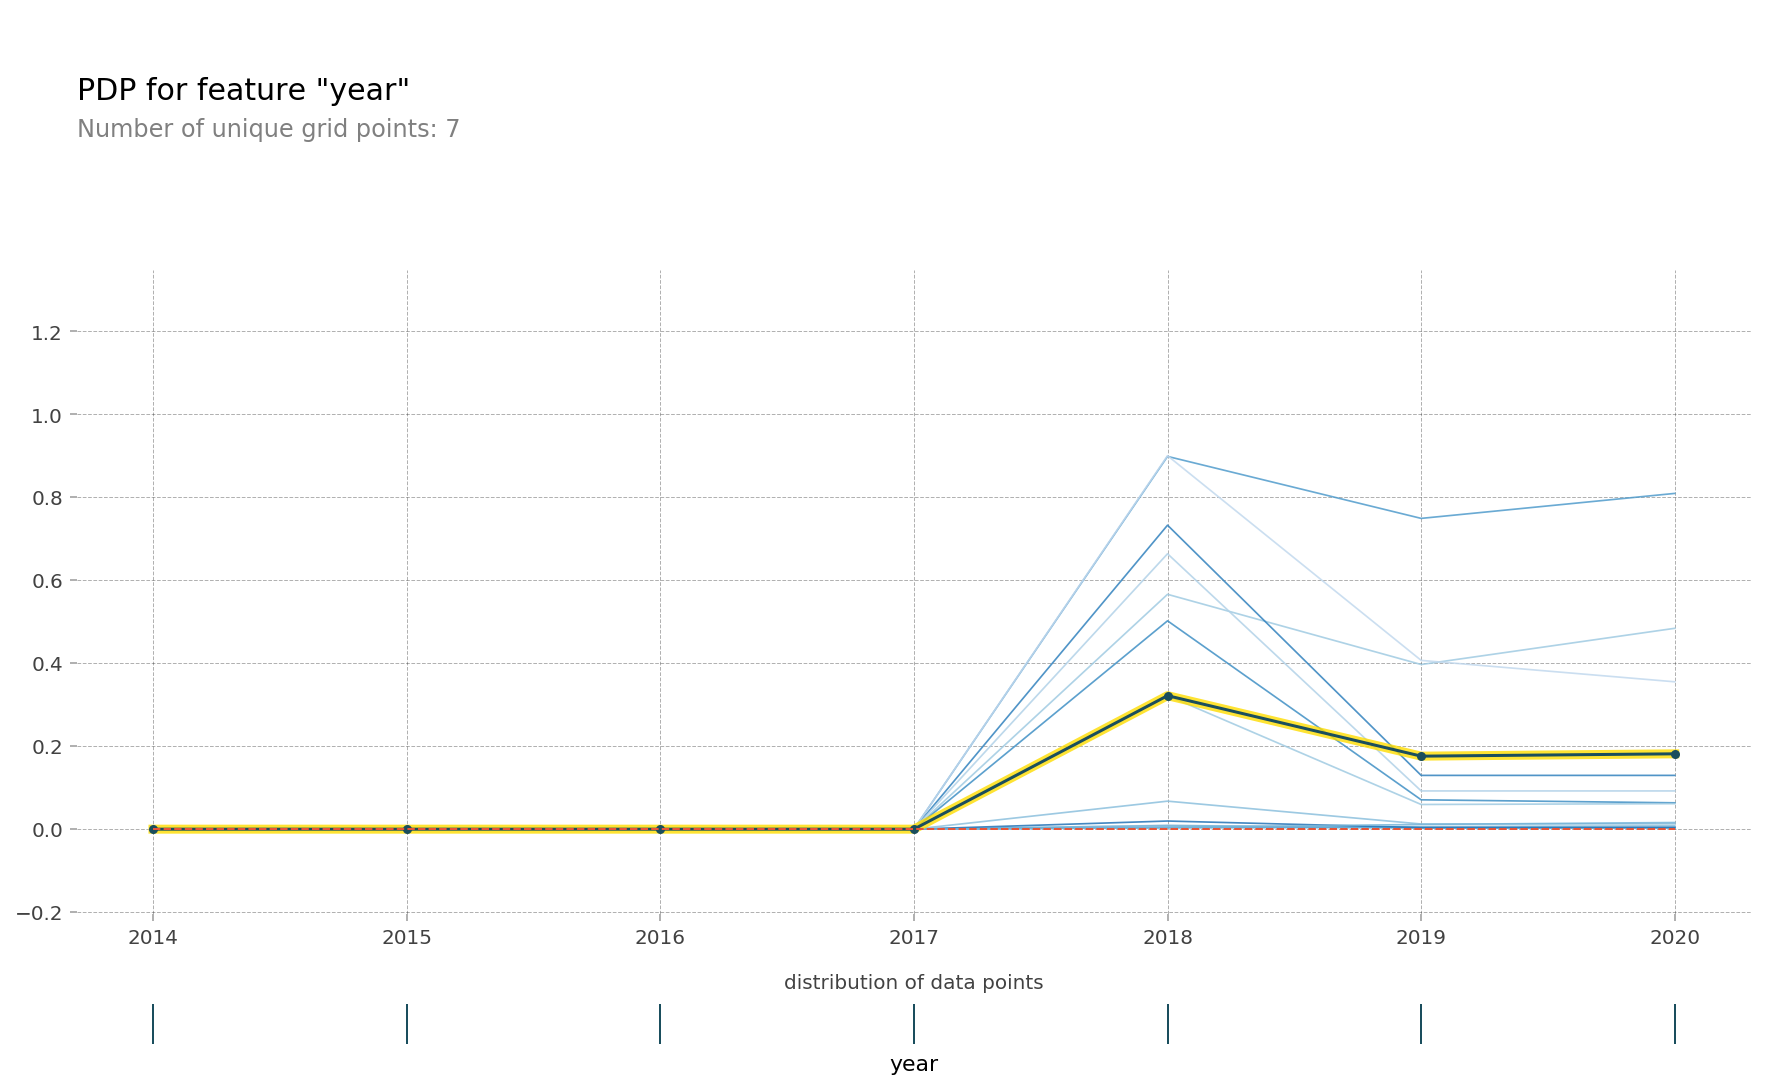

In [70]:
pdp_plot(
    isolated, 
    feature_name = target_feature,
    plot_lines = True, # ICE plots
    frac_to_plot = 15, # int type type을 입력하면 데이터의 개수가 됩니다, 
                       # float type을 입력하면 전체 데이터 개수중 plottling할 데이터 수의 비율이 된다.
    plot_pts_dist = True)
